In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from MLib.PGM.Infections import preprocess_timeseries, beta_gamma_solver,\
    learn_beta_gamma_models, extract_data, create_SIR_data, \
    get_daily_policies, create_policy_dict, RegLinearRegression
from MLib.Learners.KerasLearner import MarkovChainRNN
from MLib.PGM.PGM import Factor, Factor_Given_Continuous, \
    compute_probability_policy_change, compute_uncertainty_given_policies,\
    check_policy_change_v3
from tensorflow.keras.preprocessing.sequence import pad_sequences
import copy
from MLib.Core.metrics import MAPE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

In [2]:
# Set the starting and ending dates for computing beta and gamma
start_dates_beta = ['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',\
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',\
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',\
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',\
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25']

end_dates_beta = ['2020-04-04', '2020-04-11', '2020-04-18', '2020-04-25',\
             '2020-05-02', '2020-05-09', '2020-05-16', '2020-05-23',\
             '2020-05-30', '2020-06-06', '2020-06-13', '2020-06-20',\
             '2020-06-27', '2020-07-04', '2020-07-11', '2020-07-18',\
             '2020-07-25', '2020-08-01', '2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01']

# Set the starting and ending dates for the predictions
start_dates = ['2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25'\
              ]


end_dates = ['2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01'\
            ]

In [3]:
# Create a dictionary with the population of the provinces
population_dict = dict()
population_dict['United States'] = 328E6

all_regions = population_dict.keys()

In [4]:
# Set the path to the directory with the Oxford Policy Tracker
policy_path = './covid-policy-tracker/data/OxCGRT_latest.csv'

# Load the dataset
data = pd.read_csv(policy_path)

/home/rvega/Envs/neurips/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Estimate the betas per every day, in every province.
Params_dict = dict()

# Create a list to store a dateset with the policies and beta
country = 'United States'
all_regions = ['United States']

# Use only the features that are not constant across the entire time
policies_cardinality = {'C1_School closing':4, 'C2_Workplace closing':4, 'C3_Cancel public events':3,\
    'C4_Restrictions on gatherings':5, 'C5_Close public transport':3, 'C6_Stay at home requirements':4,\
    'C7_Restrictions on internal movement':3, 'C8_International travel controls':5, \
    'E1_Income support':3, 'E2_Debt/contract relief':3,\
    'H1_Public information campaigns':3, 'H2_Testing policy':4, 'H3_Contact tracing':3, \
    'H6_Facial Coverings':5, 'H7_Vaccination policy':6}

# Transform the daily policy into a binary vector
encoder_dict = create_policy_dict(policies_cardinality)
    
# Define the range of days to analyze, and the policies that we want
# to evaluate.
start_date = 20200327
end_date = 20210503
    
features = ['Date',\
    'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',\
    'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',\
    'C7_Restrictions on internal movement', 'C8_International travel controls', \
    'E1_Income support', 'E2_Debt/contract relief',\
    'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
    'H6_Facial Coverings', 'H7_Vaccination policy']

features = ['Date',\
    'C2_Workplace closing', 'C6_Stay at home requirements', 'H7_Vaccination policy']

for region in all_regions:
    Params_dict[region] = dict()

for region in all_regions:
    Params_dict[region]['Date'] = list()
    Params_dict[region]['Beta'] = list()
    Params_dict[region]['Gamma'] = list()
    Params_dict[region]['Holidays'] = list()
    Params_dict[region]['Policy'] = list()
    Params_dict[region]['Policy_changes'] = list()
    Params_dict[region]['ICU'] = list()
    Params_dict[region]['Hospitalizations'] = list()
    Params_dict[region]['S'] = list()
    Params_dict[region]['I'] = list()
    Params_dict[region]['R'] = list()
    Params_dict[region]['Cases'] = list()
    Params_dict[region]['Deaths'] = list()
    
    # Get the data from the current region only.
    country_flag = data['CountryName'] == country
    region_flag = data['Jurisdiction'] == 'NAT_TOTAL'
    all_flags = np.logical_and(country_flag, region_flag)
    country_data = data.loc[all_flags, :]

    dates, processed_cases, processed_deaths, country_data_features = \
        extract_data(start_date, end_date, country_data, features)

    daily_policy = get_daily_policies(country_data_features, 
                                      features, encoder_dict)

    # -----------------------------------------------------------
    # Since the number of recovered is not in the data, assume that all the people
    # who didn't die within 15 days has recovered.
    population = population_dict[region]

    S, I, R = create_SIR_data(population, processed_cases, 
                              processed_deaths, recovery_time=14)
    
    # Load the holidays data
    holidays_data = pd.read_csv('./Holidays_dataset_Countries.csv')
    holidays_Canada = np.zeros(len(S))

    temp = list()
    for i in range(len(holidays_data)):
        for j in range(7):
            temp.append(holidays_data['US'].values[i])
            
    holidays_Canada[0:len(temp)] = temp
    
    for date_str, end_date_str in zip(start_dates_beta, end_dates_beta):
#         print(date_str)
        date_parts = date_str.split('-')
        date = np.int32(''.join(date_parts))
        start_indx = np.where(dates == date)[0][0]
        last_indx = start_indx + 7
        
        S_train = S[start_indx-1:last_indx]
        I_train = I[start_indx-1:last_indx]
        R_train = R[start_indx-1:last_indx]

        beta, gamma = beta_gamma_solver(S_train, I_train, R_train)
            
        for j in range(last_indx - start_indx):
            Params_dict[region]['Date'].append(dates[start_indx+j])
            Params_dict[region]['Beta'].append(beta)
            Params_dict[region]['Gamma'].append(gamma)
            Params_dict[region]['Policy'].append(daily_policy[start_indx+j])
            Params_dict[region]['S'].append(S[start_indx+j])
            Params_dict[region]['I'].append(I[start_indx+j])
            Params_dict[region]['R'].append(R[start_indx+j])
            Params_dict[region]['Holidays'].append(holidays_Canada[start_indx+j])
            Params_dict[region]['Cases'].append(processed_cases[start_indx+j])
            Params_dict[region]['Deaths'].append(processed_deaths[start_indx+j])
            
    last_policy = Params_dict[region]['Policy'][0]
    weeks_since_change = 7

    Params_dict[region]['Weeks_since_change'] = list()

    for i in range(0,len(Params_dict[region]['Policy']),7):
        # Check if there is a change in policy during the current week
        c_policy = Params_dict[region]['Policy'][i+6]

        for j in range(7):
            Params_dict[region]['Weeks_since_change'].append(weeks_since_change)

        if np.sum(np.abs(c_policy - last_policy)) > 0:
            weeks_since_change = 0
            last_policy = c_policy
        else:
            if weeks_since_change < 7:
                weeks_since_change += 1


/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating encoder for C1_School closing
Creating encoder for C2_Workplace closing
Creating encoder for C3_Cancel public events
Creating encoder for C4_Restrictions on gatherings
Creating encoder for C5_Close public transport
Creating encoder for C6_Stay at home requirements
Creating encoder for C7_Restrictions on internal movement
Creating encoder for C8_International travel controls
Creating encoder for E1_Income support
Creating encoder for E2_Debt/contract relief
Creating encoder for H1_Public information campaigns
Creating encoder for H2_Testing policy
Creating encoder for H3_Contact tracing
Creating encoder for H6_Facial Coverings
Creating encoder for H7_Vaccination policy


In [6]:
# Create a dictionary with the population of the provinces
population_path_states = './COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
population_data_states = pd.read_csv(population_path_states)

country_flag_states = population_data_states['Country_Region'] == 'US'
admin_flag_states = population_data_states['Admin2'].fillna('Nan').values == 'Nan'

all_flags_states = np.logical_and(country_flag_states, admin_flag_states)

country_data_states = population_data_states.loc[all_flags_states, ['Province_State', 'Population', 'FIPS']]

fips_dict = dict()

states = country_data_states['Province_State'].values[6:]
populations = country_data_states['Population'].values[6:]
fips = country_data_states['FIPS'].values[6:]

for i, element in enumerate(states):
    if np.isnan(populations[i]) == False:
        if element =='District of Columbia':
            population_dict['Washington DC'] = populations[i]
            fips_dict['Washington DC'] = fips[i]
        else:
            population_dict[element] = populations[i]
            fips_dict[element] = fips[i]
        

all_regions_states = list(population_dict.keys())

for region in all_regions_states[1:]:
    Params_dict[region] = dict()

for region in all_regions_states[1:]:
    Params_dict[region]['Date'] = list()
    Params_dict[region]['Beta'] = list()
    Params_dict[region]['Gamma'] = list()
    Params_dict[region]['Holidays'] = list()
    Params_dict[region]['Policy'] = list()
    Params_dict[region]['Policy_changes'] = list()
    Params_dict[region]['ICU'] = list()
    Params_dict[region]['Hospitalizations'] = list()
    Params_dict[region]['S'] = list()
    Params_dict[region]['I'] = list()
    Params_dict[region]['R'] = list()
    Params_dict[region]['Cases'] = list()
    Params_dict[region]['Deaths'] = list()
    
    # Get the data from the current region only.
    country_flag = data['CountryName'] == country
    region_flag = data['RegionName'] == region
    all_flags = np.logical_and(country_flag, region_flag)
    country_data = data.loc[all_flags, :]

    dates, processed_cases, processed_deaths, country_data_features = \
        extract_data(start_date, end_date, country_data, features)

    daily_policy = get_daily_policies(country_data_features, 
                                      features, encoder_dict)

    # -----------------------------------------------------------
    # Since the number of recovered is not in the data, assume that all the people
    # who didn't die within 15 days has recovered.
    population = population_dict[region]

    S, I, R = create_SIR_data(population, processed_cases, 
                              processed_deaths, recovery_time=14)
    
    # Load the holidays data
    holidays_data = pd.read_csv('./Holidays_dataset_Countries.csv')
    holidays_Canada = np.zeros(len(S))

    temp = list()
    for i in range(len(holidays_data)):
        for j in range(7):
            temp.append(holidays_data['US'].values[i])
            
    holidays_Canada[0:len(temp)] = temp
    
    for date_str, end_date_str in zip(start_dates_beta, end_dates_beta):
#         print(date_str)
        date_parts = date_str.split('-')
        date = np.int32(''.join(date_parts))
        start_indx = np.where(dates == date)[0][0]
        last_indx = start_indx + 7
        
        S_train = S[start_indx-1:last_indx]
        I_train = I[start_indx-1:last_indx]
        R_train = R[start_indx-1:last_indx]

        beta, gamma = beta_gamma_solver(S_train, I_train, R_train)
            
        for j in range(last_indx - start_indx):
            Params_dict[region]['Date'].append(dates[start_indx+j])
            Params_dict[region]['Beta'].append(beta)
            Params_dict[region]['Gamma'].append(gamma)
            Params_dict[region]['Policy'].append(daily_policy[start_indx+j])
            Params_dict[region]['S'].append(S[start_indx+j])
            Params_dict[region]['I'].append(I[start_indx+j])
            Params_dict[region]['R'].append(R[start_indx+j])
            Params_dict[region]['Holidays'].append(holidays_Canada[start_indx+j])
            Params_dict[region]['Cases'].append(processed_cases[start_indx+j])
            Params_dict[region]['Deaths'].append(processed_deaths[start_indx+j])
            
    last_policy = Params_dict[region]['Policy'][0]
    weeks_since_change = 7

    Params_dict[region]['Weeks_since_change'] = list()

    for i in range(0,len(Params_dict[region]['Policy']),7):
        # Check if there is a change in policy during the current week
        c_policy = Params_dict[region]['Policy'][i+6]

        for j in range(7):
            Params_dict[region]['Weeks_since_change'].append(weeks_since_change)

        if np.sum(np.abs(c_policy - last_policy)) > 0:
            weeks_since_change = 0
            last_policy = c_policy
        else:
            if weeks_since_change < 7:
                weeks_since_change += 1


/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home

/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/neurips/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home

In [7]:
# Create the dataset for the NN-CPD
prob_tuple = np.array([
    [125, 0, 0.01, 0.98, 0.01],
    [200, 0, 0, 0.95, 0.05],
    [50, 0, 0.05, 0.95, 0],
    [125, -20, 0.05, 0.95, 0],
    [125, 20, 0, 0.95, 0.05],
    [200, 20, 0, 0.1, 0.9],
    [200, 40, 0, 0, 1],
    [50, -20, 0.9, 0.1, 0],
    [50, 20, 0, 1, 0],
    [200,-20, 0, 1, 0],
    [0, -40, 1, 0, 0],
    [250,40, 0, 0, 1]
])

In [8]:
# Train the NN-CPD
nn_model = keras.Sequential(
    [
        layers.Dense(64, activation='sigmoid', name='hidden_1'),
        layers.Dense(3, activation='softmax', name='output')
    ]
)

x = np.ones((3,2))
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction="auto", name="categorical_crossentropy"
)

optimizer_fn = tf.keras.optimizers.Adam(
    learning_rate=1E-3
)

nn_model.compile(optimizer=optimizer_fn,
              loss=loss_fn)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=1E-5, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

nn_model.fit(prob_tuple[:,0:2], prob_tuple[:,2:], verbose=1, epochs=10000, callbacks=[early_stopping])

Epoch 1/10000
1/1 [==============================] - 0s 316ms/step - loss: 2.2447
Epoch 2/10000
1/1 [==============================] - 0s 4ms/step - loss: 2.2023
Epoch 3/10000
1/1 [==============================] - 0s 4ms/step - loss: 2.1600
Epoch 4/10000
1/1 [==============================] - 0s 5ms/step - loss: 2.1178
Epoch 5/10000
1/1 [==============================] - 0s 5ms/step - loss: 2.0759
Epoch 6/10000
1/1 [==============================] - 0s 5ms/step - loss: 2.0341
Epoch 7/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.9926
Epoch 8/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.9512
Epoch 9/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.9101
Epoch 10/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.8692
Epoch 11/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.8286
Epoch 12/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.7881
Epoch 13/10000
1/1 [===============

1/1 [==============================] - 0s 3ms/step - loss: 0.4348
Epoch 102/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.4323
Epoch 103/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.4299
Epoch 104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.4274
Epoch 105/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.4251
Epoch 106/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.4228
Epoch 107/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.4206
Epoch 108/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4185
Epoch 109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4164
Epoch 110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4144
Epoch 111/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4123
Epoch 112/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4103
Epoch 113/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2950
Epoch 203/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2943
Epoch 204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2937
Epoch 205/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2930
Epoch 206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2923
Epoch 207/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2917
Epoch 208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2910
Epoch 209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2904
Epoch 210/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2897
Epoch 211/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2891
Epoch 212/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2885
Epoch 213/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.2554
Epoch 302/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2551
Epoch 303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2548
Epoch 304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2545
Epoch 305/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2542
Epoch 306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2540
Epoch 307/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2537
Epoch 308/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2534
Epoch 309/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2531
Epoch 310/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2528
Epoch 311/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2525
Epoch 312/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2523
Epoch 313/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.2307
Epoch 402/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2305
Epoch 403/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2303
Epoch 404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2301
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2298
Epoch 406/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2296
Epoch 407/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2294
Epoch 408/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2292
Epoch 409/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2290
Epoch 410/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2288
Epoch 411/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2287
Epoch 412/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.2285
Epoch 413/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.2125
Epoch 501/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2124
Epoch 502/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2122
Epoch 503/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2120
Epoch 504/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2119
Epoch 505/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2117
Epoch 506/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2115
Epoch 507/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2114
Epoch 508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2112
Epoch 509/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2110
Epoch 510/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2109
Epoch 511/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2107
Epoch 512/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1960
Epoch 601/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1958
Epoch 602/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1956
Epoch 603/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1954
Epoch 604/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1953
Epoch 605/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1951
Epoch 606/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1949
Epoch 607/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1948
Epoch 608/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1946
Epoch 609/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1944
Epoch 610/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1942
Epoch 611/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1941
Epoch 612/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.1796
Epoch 700/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 701/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1793
Epoch 702/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1791
Epoch 703/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1789
Epoch 704/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 705/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1786
Epoch 706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1784
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1782
Epoch 708/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1781
Epoch 709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1779
Epoch 710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1777
Epoch 711/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1668
Epoch 800/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1667
Epoch 801/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1666
Epoch 802/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 803/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1664
Epoch 804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1663
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1662
Epoch 806/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1660
Epoch 808/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1659
Epoch 809/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1658
Epoch 810/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1658
Epoch 811/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1586
Epoch 900/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1586
Epoch 901/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1585
Epoch 902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1584
Epoch 903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1584
Epoch 904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1583
Epoch 905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1583
Epoch 906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1582
Epoch 907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1581
Epoch 908/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1581
Epoch 909/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1580
Epoch 910/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1579
Epoch 911/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.1526
Epoch 1000/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1525
Epoch 1001/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1525
Epoch 1002/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1524
Epoch 1003/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1524
Epoch 1004/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1523
Epoch 1005/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1522
Epoch 1006/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1522
Epoch 1007/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1521
Epoch 1008/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1521
Epoch 1009/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1520
Epoch 1010/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1520
Epoch 1011/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1480
Epoch 1098/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1479
Epoch 1099/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1479
Epoch 1100/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1479
Epoch 1101/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1478
Epoch 1102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1478
Epoch 1103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1478
Epoch 1104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1477
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1477
Epoch 1106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1477
Epoch 1107/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1476
Epoch 1108/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1476
Epoch 1109/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.1445
Epoch 1196/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 1197/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 1198/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 1199/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1444
Epoch 1200/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1443
Epoch 1201/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1443
Epoch 1202/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1443
Epoch 1203/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1442
Epoch 1204/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1442
Epoch 1205/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1442
Epoch 1206/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1441
Epoch 1207/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.1418
Epoch 1294/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1418
Epoch 1295/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1418
Epoch 1296/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 1297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 1298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 1299/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 1300/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1416
Epoch 1301/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1416
Epoch 1302/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1416
Epoch 1303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1416
Epoch 1304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1415
Epoch 1305/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1398
Epoch 1392/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 1393/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 1394/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1397
Epoch 1395/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 1396/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 1397/10000
1/1 [==============================] - ETA: 0s - loss: 0.139 - 0s 3ms/step - loss: 0.1396
Epoch 1398/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.1396
Epoch 1399/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1396
Epoch 1400/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1396
Epoch 1401/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1396
Epoch 1402/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.13

1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1490/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1491/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1492/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 1495/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1382
Epoch 1496/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1381
Epoch 1497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1381
Epoch 1498/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1381
Epoch 1499/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1381
Epoch 1500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1381
Epoch 1501/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1370
Epoch 1588/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370
Epoch 1589/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1370
Epoch 1590/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370
Epoch 1591/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1370
Epoch 1592/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1369
Epoch 1593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1369
Epoch 1594/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1369
Epoch 1595/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1369
Epoch 1596/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.1369
Epoch 1597/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1369
Epoch 1598/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1369
Epoch 1599/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.1361
Epoch 1686/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1361
Epoch 1687/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1688/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.1360
Epoch 1689/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1690/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1691/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1693/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1695/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1696/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1360
Epoch 1697/10000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 1784/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 1785/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 1786/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 1787/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 1788/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 1789/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 1790/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1352
Epoch 1791/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1352
Epoch 1792/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1352
Epoch 1793/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1352
Epoch 1794/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1352
Epoch 1795/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.1346
Epoch 1882/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1346
Epoch 1883/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1346
Epoch 1884/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1346
Epoch 1885/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1346
Epoch 1886/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1346
Epoch 1887/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1346
Epoch 1888/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1346
Epoch 1889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1346
Epoch 1890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1346
Epoch 1891/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1346
Epoch 1892/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1345
Epoch 1893/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1980/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1981/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1340
Epoch 1982/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1983/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1340
Epoch 1984/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1985/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1986/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 1987/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1339
Epoch 1988/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1339
Epoch 1989/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1339
Epoch 1990/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1339
Epoch 1991/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1334
Epoch 2078/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1334
Epoch 2079/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1334
Epoch 2080/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1334
Epoch 2081/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1334
Epoch 2082/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1333
Epoch 2083/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1333
Epoch 2084/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1333
Epoch 2085/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1333
Epoch 2086/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1333
Epoch 2087/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1333
Epoch 2088/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1333
Epoch 2089/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.1329
Epoch 2176/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2177/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2178/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1329
Epoch 2179/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1329
Epoch 2182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2185/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1329
Epoch 2186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1329
Epoch 2187/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.1325
Epoch 2274/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2275/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2276/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2277/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2281/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1325
Epoch 2282/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1325
Epoch 2283/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2284/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1325
Epoch 2285/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1323
Epoch 2372/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1323
Epoch 2373/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1323
Epoch 2374/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2375/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2376/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2378/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2379/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2381/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2382/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 2383/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.1320
Epoch 2470/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2471/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1320
Epoch 2472/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1320
Epoch 2473/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2474/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1320
Epoch 2476/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2477/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2478/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2479/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2480/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1320
Epoch 2481/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2568/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2569/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2570/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1318
Epoch 2571/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2573/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1318
Epoch 2576/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1318
Epoch 2577/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 2578/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1318
Epoch 2579/10000
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.1316
Epoch 2666/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2667/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1316
Epoch 2668/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1316
Epoch 2669/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2670/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1316
Epoch 2671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2672/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2673/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2674/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2675/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1316
Epoch 2676/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2677/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1315
Epoch 2764/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.1315
Epoch 2765/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1315
Epoch 2766/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1315
Epoch 2767/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1315
Epoch 2768/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1315
Epoch 2769/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.1315
Epoch 2770/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1314
Epoch 2771/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1314
Epoch 2772/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1314
Epoch 2773/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1314
Epoch 2774/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 2775/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.1313
Epoch 2862/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 2863/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 2864/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 2865/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1313
Epoch 2866/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1313
Epoch 2867/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1313
Epoch 2868/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1313
Epoch 2869/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1313
Epoch 2870/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.1313
Epoch 2871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1313
Epoch 2872/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1313
Epoch 2873/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 2960/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 2961/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 2962/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 2963/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 2964/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 2965/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 2966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1312
Epoch 2967/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 2968/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1312
Epoch 2969/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1312
Epoch 2970/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1312
Epoch 2971/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 3058/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3059/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3060/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3064/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3065/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3066/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 3067/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 3068/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1311
Epoch 3069/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3156/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 3157/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 3158/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3159/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3160/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3162/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3163/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3164/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.1310
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 3166/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 3167/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.1309
Epoch 3254/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3255/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3256/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3258/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 3259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3260/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3261/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3262/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3263/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3264/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1309
Epoch 3265/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.1310
Epoch 3352/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1309
Epoch 3353/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1308
Epoch 3354/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1308
Epoch 3355/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1309
Epoch 3356/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1309
Epoch 3357/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1309
Epoch 3358/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 3359/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1308
Epoch 3360/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1308
Epoch 3361/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3362/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 3363/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.1308
Epoch 3450/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1308
Epoch 3451/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1308
Epoch 3452/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1308
Epoch 3453/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.1308
Epoch 3454/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.1308
Epoch 3455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1308
Epoch 3456/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3457/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3458/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1307
Epoch 3459/10000
1/1 [==============================] - ETA: 0s - loss: 0.130 - 0s 4ms/step - loss: 0.1307
Epoch 3460/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.13

1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3548/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3549/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3550/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3551/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3552/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3553/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3554/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 3556/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3557/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3558/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 3559/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3646/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3647/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3648/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3649/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3650/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3651/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3652/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3653/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3654/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3655/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3656/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3657/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.1306
Epoch 3744/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3745/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3746/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3748/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1306
Epoch 3749/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1306
Epoch 3750/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3751/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3752/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3753/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1306
Epoch 3754/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3755/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3842/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1305
Epoch 3843/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3844/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3845/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.1305
Epoch 3846/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1305
Epoch 3847/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1305
Epoch 3848/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.1305
Epoch 3849/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3850/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.1305
Epoch 3851/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3852/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 3853/10000
1/1

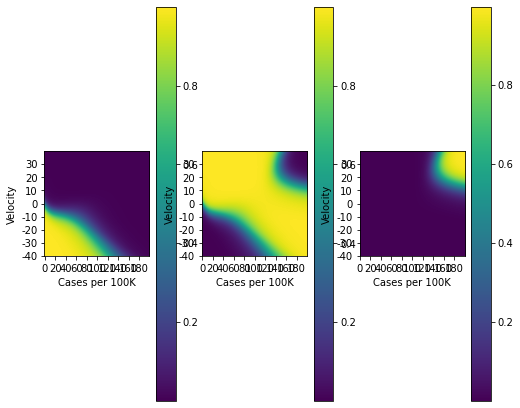

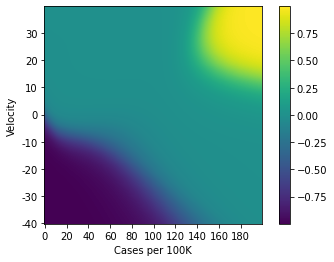

In [9]:
# Visualize the NN-CPD
cases_lin = np.linspace(0, 200, 200)
vel_lin = np.linspace(-40, 40, 200)
xy = np.meshgrid(cases_lin, vel_lin)

probabilities = np.zeros([len(cases_lin), len(vel_lin), 3])

for i in range(len(cases_lin)):
    c_tuple = np.hstack([np.reshape(xy[0][0], (-1,1)), np.reshape(xy[1][i], (-1,1))])
    prob = nn_model(c_tuple)
    probabilities[i,:,:] = prob.numpy()
    
plt.figure(figsize=(8,8))

plt.subplot(1,3,1)
plt.imshow(probabilities[:,:,0], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,2)
plt.imshow(probabilities[:,:,1], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,3)
plt.imshow(probabilities[:,:,2], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

new_plot = probabilities[:,:,2] + probabilities[:,:,0]*-1

plt.figure()
plt.imshow(new_plot, origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

In [10]:
id_weeks_since_change = 1
id_openness_to_change = 2
id_change_policy = 3
id_need_to_change = 4

variables = np.array([id_openness_to_change, id_weeks_since_change])
cardinality = np.array([2, 8])
values = np.array([1, 0.9, 0.85, 0.75, 0.50, 0.25, 0, 0, 
                   0, 0.1, 0.15, 0.25, 0.50, 0.75, 1, 1])
values = np.array([0, 0, 0, 0, 0, 0, 0, 0, 
                   1, 1, 1, 1, 1, 1, 1, 1])
openness_to_change = Factor(variables, cardinality, values)

variables = np.array([id_change_policy, id_openness_to_change, id_need_to_change])
cardinality = np.array([3, 2, 3])
value = np.array([
    0.02, 0.005, 0.01, 0.8, 0.09, 0.01,
    0.97, .99, 0.97, 0.19, 0.9, 0.24,
    0.01, .005, 0.02, 0.01, 0.01, 0.75
])
change_policy = Factor(variables, cardinality, value)

variables = np.array([id_need_to_change])
cardinality = np.array([3])
need_to_change = Factor_Given_Continuous(variables, cardinality, nn_model)

Factor_list = [openness_to_change, need_to_change, change_policy]

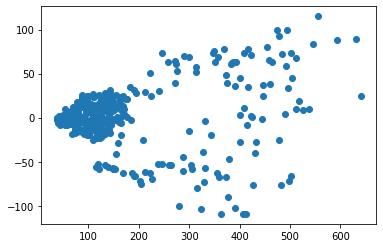

----------------------------------------------------------
Predicting 2020-08-02
Week  0

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.06819595484345542 0.04964595161284356
Prediction model
450080.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 -3.329573170731692 119.90487804878049
Predicted Policy
[0.08986367 0.89846278 0.01167355]
Current Delta
6993.634294460062
Real cases:  377105.0
Predicted cases:  450080.0
Mixed cases:  449289.63429446006
Sames as last:  442296.0
MAPE 0.1914178658316916

 Weeks in advance 2
Beta, Gamma
0.06627711044722123 0.046484532772156195
Prediction model
488352.0
Uncertainty
[0.08986367 0.89846278 0.01167355]


/home/rvega/Envs/neurips/lib/python3.6/site-packages/MLib/PGM/PGM.py:176: RuntimeWarning: divide by zero encountered in log
  new_prob = np.add(np.log(factor_A.values[index_A]), np.log(factor_B.values[index_B]))


Weeks Angle Percentage
0 -3.329573170731692 119.90487804878049
Predicted Policy
[0.08986367 0.89846278 0.01167355]
Current Delta
41379.601884076954
Real cases:  361003.0
Predicted cases:  488352.0
Mixed cases:  483675.60188407695
Sames as last:  442296.0
MAPE 0.33981047770815465

 Weeks in advance 3
Beta, Gamma
0.06356193427739679 0.04294782705084638
Prediction model
526112.0
Uncertainty
[0.08986367 0.89846278 0.01167355]
Weeks Angle Percentage
0 -3.329573170731692 119.90487804878049
Predicted Policy
[0.08986367 0.89846278 0.01167355]
Current Delta
75305.55652935104
Real cases:  304175.0
Predicted cases:  526112.0
Mixed cases:  517601.55652935104
Sames as last:  442296.0
MAPE 0.7016571267505582

 Weeks in advance 4
Beta, Gamma
0.06049063041145161 0.03578568312847896
Prediction model
570880.0
Uncertainty
[0.08986367 0.89846278 0.01167355]
Weeks Angle Percentage
0 -3.329573170731692 119.90487804878049
Predicted Policy
[0.08986367 0.89846278 0.01167355]
Current Delta
115527.93835031579
Re

Week  5

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.07087023471864351 0.06291710010086718
Prediction model
288992.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
5 -0.47926829268291726 91.95609756097562
Predicted Policy
[0.08991564 0.89874079 0.01134357]
Current Delta
-1209.705098601582
Real cases:  241099.0
Predicted cases:  288992.0
Mixed cases:  289128.2949013984
Sames as last:  290338.0
MAPE 0.19920984699811453

 Weeks in advance 2
Beta, Gamma
0.06889416759885574 0.05918453955435987
Prediction model
293376.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
5 -0.47926829268291726 91.95609756097562
Predicted Policy
[0.08991564 0.89874079 0.01134357]
Current Delta
2730.374509325251
Real cases:  283884.0
Predicted cases:  293376.0
Mixed cases:  293068.37450932525
Sames as last:  290338.0
MAPE 0.03235256129026381

 Weeks in advance 3
Beta, Gamma
0.06747567460602105 0.05331413418657804

Uncertainty
[0.08989307 0.89863133 0.0114756 ]
Weeks Angle Percentage
7 -2.4301829268292607 103.58079268292683
Predicted Policy
[0.08989307 0.89863133 0.0114756 ]
Current Delta
70000.68473460746
Real cases:  483324.0
Predicted cases:  380672.0
Mixed cases:  372775.68473460746
Sames as last:  302775.0
MAPE 0.22872506903317968

 Weeks in advance 4
Beta, Gamma
0.0694871922190825 0.04402667564505193
Prediction model
430080.0
Uncertainty
[0.1706738  0.80753827 0.02178793]
Weeks Angle Percentage
7 -2.4301829268292607 103.58079268292683
Predicted Policy
[0.08989307 0.89863133 0.0114756 ]
Current Delta
114400.26150094619
Real cases:  565777.0
Predicted cases:  430080.0
Mixed cases:  417175.2615009462
Sames as last:  302775.0
MAPE 0.26265072369335235
----------------------------------------------------------
Predicting 2020-10-11
Week  10

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.0819239

Week  14

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]

 Weeks in advance 1
Beta, Gamma
0.1 0.04634243813164066
Prediction model
1084704.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 64.06189024390244 271.99695121951225
Predicted Policy
[0.08955283 0.89612672 0.01432044]
Current Delta
249136.67127963668
Real cases:  1035756.0
Predicted cases:  1084704.0
Mixed cases:  1055825.6712796367
Sames as last:  806689.0
MAPE 0.01937683323064185

 Weeks in advance 2
Beta, Gamma
0.0929571776955886 0.0419352582307215
Prediction model
1388288.0
Uncertainty
[0.08955283 0.89612672 0.01432044]
Weeks Angle Percentage
0 64.06189024390244 271.99695121951225
Predicted Policy
[0.08955283 0.89612672 0.01432044]
Current Delta
521186.40677504963
Real cases:  1205387.0
Predicted cases:  1388288.0
Mixed cases:  1327875.4067750496
Sames as last:  806689.0
MAPE 0.10161749444373436

 Weeks in advance 3
Beta, Gamma
0.08615391538847761 0.038915

Week  19

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]

 Weeks in advance 1
Beta, Gamma
0.08375478287507351 0.05183269508118885
Prediction model
1738624.0
Uncertainty
[1. 0. 0.]
Weeks Angle Percentage
0 62.93414634146336 464.35823170731715
Predicted Policy
[0.  0.3 0.7]
Current Delta
67993.79999999981
Real cases:  1521830.0
Predicted cases:  1738624.0
Mixed cases:  1579971.7999999998
Sames as last:  1511978.0
MAPE 0.03820518717596565

 Weeks in advance 2
Beta, Gamma
0.07472537795054232 0.04994630943791335
Prediction model
1736864.0
Uncertainty
[0.  0.3 0.7]
Weeks Angle Percentage
0 62.93414634146336 464.35823170731715
Predicted Policy
[0.  0.3 0.7]
Current Delta
67465.79999999981
Real cases:  1332635.0
Predicted cases:  1736864.0
Mixed cases:  1579443.7999999998
Sames as last:  1511978.0
MAPE 0.18520360038570188

 Weeks in advance 3
Beta, Gamma
0.06706328290511339 0.04357702714370076
Prediction model
1732736.0
Uncert

Week  24

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.06869949089388525 0.05634811412238825
Prediction model
1494368.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -40.46981707317076 430.4146341463415
Predicted Policy
[0.  0.3 0.7]
Current Delta
-21382.200000000186
Real cases:  1236324.0
Predicted cases:  1494368.0
Mixed cases:  1544259.7999999998
Sames as last:  1565642.0
MAPE 0.24907370559820874

 Weeks in advance 2
Beta, Gamma
0.06962361606308469 0.04997168522648102
Prediction model
1598752.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
3 -40.46981707317076 430.4146341463415
Predicted Policy
[0.  0.3 0.7]
Current Delta
9933.0
Real cases:  1062006.0
Predicted cases:  1598752.0
Mixed cases:  1575575.0
Sames as last:  1565642.0
MAPE 0.48358389688947145

 Weeks in advance 3
Beta, Gamma
0.06960090217329501 0.04597582350997105
Prediction model
1693888.0
Uncertainty
[0.  0.3 0.7]
W

Week  29

 Predicting on region  United States 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

 Weeks in advance 1
Beta, Gamma
0.05343166892787467 0.07240244157416209
Prediction model
362272.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -58.46646341463415 152.64481707317074
Predicted Policy
[0.08985093 0.89674773 0.01340135]
Current Delta
-99106.76541629952
Real cases:  479717.0
Predicted cases:  362272.0
Mixed cases:  373683.2345837005
Sames as last:  472790.0
MAPE 0.22103399591071302

 Weeks in advance 2
Beta, Gamma
0.05323153705605769 0.07049984813178549
Prediction model
300064.0
Uncertainty
[0. 1. 0.]
Weeks Angle Percentage
7 -58.46646341463415 152.64481707317074
Predicted Policy
[0.08985093 0.89674773 0.01340135]
Current Delta
-154891.64808715088
Real cases:  426544.0
Predicted cases:  300064.0
Mixed cases:  317898.3519128491
Sames as last:  472790.0
MAPE 0.25471146725109456

 Weeks in advance 3
Beta, Gamma
0.052689969706925306 0.0669451860636576

Prediction model
377920.0
Uncertainty
[0.08985912 0.89843162 0.01170927]
Weeks Angle Percentage
1 -0.2213414634146602 118.17621951219513
Predicted Policy
[0.08985912 0.89843162 0.01170927]
Current Delta
-6828.978707159928
Real cases:  477344.0
Predicted cases:  377920.0
Mixed cases:  378692.0212928401
Sames as last:  385521.0
MAPE 0.20666852145865441

 Weeks in advance 4
Beta, Gamma
0.07252661374209088 0.05646558570820858
Prediction model
386976.0
Uncertainty
[0.08985912 0.89843162 0.01170927]
Weeks Angle Percentage
1 -0.2213414634146602 118.17621951219513
Predicted Policy
[0.08985912 0.89843162 0.01170927]
Current Delta
1307.2180001207162
Real cases:  476516.0
Predicted cases:  386976.0
Mixed cases:  386828.2180001207
Sames as last:  385521.0
MAPE 0.18821567796229147
----------------------------------------------------------
Predicting 2021-03-28
Week  34

 Predicting on region  United States 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [1 0 0]

 Weeks in adva

Week  38

 Predicting on region  United States 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]

 Weeks in advance 1
Beta, Gamma
0.06862477555621928 0.06044512581132711
Prediction model
389248.0
Uncertainty
[0. 0. 1.]
Weeks Angle Percentage
2 -22.7341463414634 113.8844512195122
Predicted Policy
[0.08992132 0.8987027  0.01137598]
Current Delta
-25030.667484168254
Real cases:  347161.0
Predicted cases:  389248.0
Mixed cases:  392069.33251583175
Sames as last:  417100.0
MAPE 0.1293588061903029

 Weeks in advance 2
Beta, Gamma
0.06879486830114341 0.058255058689020624
Prediction model
393280.0
Uncertainty
[0.08992132 0.8987027  0.01137598]
Weeks Angle Percentage
2 -22.7341463414634 113.8844512195122
Predicted Policy
[0.08992132 0.8987027  0.01137598]
Current Delta
-21407.09821459459
Real cases:  None
Predicted cases:  393280.0
Mixed cases:  395692.9017854054
Sames as last:  417100.0

 Weeks in advance 3
Beta, Gamma
0.06816689573778036 0.05654518586403223
Predict

In [11]:
# Make predictions only for the following regions.
# This experiment is NOT leave-one-province-out. We take only the information that
# is available until the prediction date across all the provinces in the list 'all_regions'

# Create the dictionaries that will store the predictions
# --------------------------
results_dict = dict()
for element in all_regions:
    results_dict[element] = dict()
    
    results_dict[element]['Start_date'] = list()
    results_dict[element]['End_date'] = list()
    results_dict[element]['Beta'] = list()
    results_dict[element]['Gamma'] = list()
    results_dict['Predicted_Deaths'] = list()
    results_dict['Real_Deaths'] = list()
    
    for i in range(1,5):
        results_dict[element]['Predicted_Cases_W_'+ str(i)] = list()
        results_dict[element]['Mixed_Cases_W_'+ str(i)] = list()
        results_dict[element]['Real_Cases_W_'+ str(i)] = list()
        results_dict[element]['Sames_as_last_W_'+ str(i)] = list()

# Set how many days in the past do we have to look for        
policy_delay = 21
beta_delay = 21
holiday_delay = 14

max_delay = np.max([policy_delay, beta_delay])

# Compute the quantities needed for predicting the probability of change in policy
for region in all_regions:
    population = population_dict[region]

    angles = list()
    num_steps_back = 7
    critical_num_cases = 1/7
    cases_per_100K = np.array(Params_dict[region]['Cases'])*100000/population

    for i in range(len(cases_per_100K)):
        if i < num_steps_back*2:
            angles.append(0)
        else:
            slope = np.sum(cases_per_100K[i-7:i]) - np.sum(cases_per_100K[i-14:i-7])
            angles.append(slope)

    plt.figure()
    plt.scatter(cases_per_100K/critical_num_cases, angles)
    plt.show()

    Params_dict[region]['Angles'] = angles
    Params_dict[region]['Percentage_Critical'] = cases_per_100K/critical_num_cases
    
# Everyday, make a predictions for the next 1, ..., 4 weeks
for i in range(len(start_dates)):
    c_start_date = start_dates[i]
    c_end_date = end_dates[i]
    print('----------------------------------------------------------')
    print('Predicting ' + c_start_date, end='\n', flush=True)
    print('Week ', i)

    # Create a dataset that contains all the number of cases seen until now
    X_train_beta = list()
    X_train_gamma = list()
    beta_train = list()
    gamma_train = list()

    for region in all_regions_states:
        # Find the index corresponding to the current week to predict in the dictionary that
        # contains all the data
        date_parts = c_start_date.split('-')
        date = np.int32(''.join(date_parts))
        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
    

        for j in range(max_delay, start_indx):
            c_Beta_1 = np.mean(Params_dict[region]['Beta'][j-7:j])
            c_Beta_2 = np.mean(Params_dict[region]['Beta'][j-14:j-7])
            c_Beta_3 = np.mean(Params_dict[region]['Beta'][j-21:j-14])

            c_Gamma_1 = np.mean(Params_dict[region]['Gamma'][j-7:j])
            c_Gamma_2 = np.mean(Params_dict[region]['Gamma'][j-14:j-7])
            c_Gamma_3 = np.mean(Params_dict[region]['Gamma'][j-21:j-14])

            c_Holiday = np.array(Params_dict[region]['Holidays'][j-holiday_delay])

            feature_vector_beta = np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3])
            feature_vector_gamma = np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3])
            if np.sum(np.isnan(feature_vector_beta)) == 0 and np.sum(np.isnan(feature_vector_beta)) == 0:
                X_train_beta.append(feature_vector_beta)
                X_train_gamma.append(feature_vector_gamma)
                beta_train.append(Params_dict[region]['Beta'][j])
                gamma_train.append(Params_dict[region]['Gamma'][j])
                

    # Format the training set
    X_train_beta = np.array(X_train_beta)
    X_train_gamma = np.array(X_train_gamma)

    beta_train = np.reshape(beta_train, (-1,1))
    gamma_train = np.reshape(gamma_train, (-1,1))

    # Learn a model that predicts the next values of beta and gamma
    # Do not regularize the terms that depend on beta or gamma
    alpha = np.ones(X_train_beta.shape[1])
    alpha[-3:] = 0.0

    ridge_model_beta, _ = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)

    _, ridge_model_gamma = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)
    
    # --------------------------------------------------------------
    # Now test it
    # --------------------------------------------------------------
    X_test = [np.ones((7, 3))]
    X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

    for region in all_regions:
        print('\n Predicting on region ', region, '\n')
        population = population_dict[region]

        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
        
        # Get the S, I, R, that is visible up to the prediction date
        S = Params_dict[region]['S']
        I = Params_dict[region]['I']
        R = Params_dict[region]['R']

        visible_S = S[0:start_indx]
        visible_I = I[0:start_indx]
        visible_R = R[0:start_indx]

        init_data = np.array([ [visible_S[-1], visible_I[-1], visible_R[-1] ] ],
                 dtype=np.float32)
        last_week_cases = visible_S[-8] - visible_S[-1]
        last_week_removed = visible_R[-1] - visible_R[-8]

        # Compute the Beta and Gamma
        c_Beta_1 = np.mean(Params_dict[region]['Beta']
                           [start_indx-7:start_indx])
        c_Beta_2 = np.mean(Params_dict[region]['Beta']
                           [start_indx-14:start_indx-7])
        c_Beta_3 = np.mean(Params_dict[region]['Beta']
                           [start_indx-21:start_indx-14])

        c_Gamma_1 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-7:start_indx])
        c_Gamma_2 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-14:start_indx-7])
        c_Gamma_3 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-21:start_indx-14])

        # Check if there was a change in policy in t-4 to t-2
        start_index_policy = start_indx - policy_delay + 14
        c_Policy_0 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay + 7
        c_Policy_1 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay
        c_Policy_2 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay - 7
        c_Policy_3 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        print('Policy t-1', c_Policy_0)
        print('Policy t-2', c_Policy_1)
        print('Policy t-3', c_Policy_2)
        print('Policy t-4', c_Policy_3)
        
        deltas = np.array(Params_dict[region]['Cases'])[1:start_indx] - \
            np.array(Params_dict[region]['Cases'])[0:start_indx-1]
        mean_delta = np.max(deltas)
        std_delta = np.std(deltas)
        
        # Make a prediction per every week
        uncertainty_flag = False
        
        for week_id in range(4):
            print('\n Weeks in advance', week_id + 1)
            # Compute the predictions and the ground truth
            init_index = start_indx - 1 + 7*week_id
            S_real = S[init_index:init_index+8]

            # Estimate the Beta and Gamma for the week to predict
            try:
                c_Holiday = np.array(Params_dict[region]['Holidays']
                         [start_indx-holiday_delay + week_id*7])
            except:
                c_Holiday=0
            feature_vector_beta = np.reshape(
                np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3]), (1,-1))
            feature_vector_gamma = np.reshape(
                np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3]), (1,-1))

            c_Beta = ridge_model_beta.predict(feature_vector_beta)[0][0]
            c_Gamma = ridge_model_gamma.predict(feature_vector_gamma)[0][0]
            
            if c_Beta < 0:
                c_Beta = .001
            if c_Beta > 0.1:
                c_Beta = 0.1

            if c_Gamma < 0:
                c_Gamma = .001
            if c_Gamma > 0.1:
                c_Gamma = 0.1
            
            print('Beta, Gamma')
            print(c_Beta, c_Gamma)
            # Create three predictions. One if the policy is relaxed, one if it stays the same
            # and one if it more strict.
            
            # Make the prediction if the policy stays the same
            # --------------------------------------------
            rnn = MarkovChainRNN(population)
            X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
            rnn.predict(X, init_data)

            # Set the weights of the network
            rnn.model.set_weights([np.array([c_Beta], dtype=np.float32),
                                  np.array([c_Gamma], dtype=np.float32)])

            # Make the prediction
            prediction, pred_state = rnn.predict(X_test, init_data)
            no_change_prediction_cases = np.array(init_data[0][0] - prediction.numpy()[0][0])
            no_change_prediction_removed = np.array(prediction.numpy()[0][2] - init_data[0][2])
            print('Prediction model')
            print(no_change_prediction_cases)
            # Make the prediction if the policy is more strict
            # --------------------------------------------
            strict_prediction_cases = last_week_cases
            strict_prediction_removed = last_week_removed

            # Make the prediction if the policy is relaxed
            # --------------------------------------------
            relaxed_prediction_cases = last_week_cases
            relaxed_prediction_removed = last_week_removed

            # Get the uncertainty in the prediction
            # --------------------------------------------                        
            if uncertainty_flag == False:
                uncertainty = compute_uncertainty_given_policies(c_Policy_1, c_Policy_2, c_Policy_3)
                if uncertainty[0] == 1 or uncertainty[2] == 1:
                    uncertainty_flag = True
            print('Uncertainty')
            print(uncertainty)
            
            # Compute the probability that there is going to be a change in policy the next week
            weeks_since_change = Params_dict[region]['Weeks_since_change'][start_indx - 1]
            angle = Params_dict[region]['Angles'][start_indx - 1]
            percentage_critical = Params_dict[region]['Percentage_Critical'][start_indx - 1]

            if percentage_critical > 350:
                c_Policy = np.array([0,0.3,0.7])
            elif percentage_critical > 400:
                c_Policy = np.array([0,0,1])
            else:
                c_Policy = compute_probability_policy_change(Factor_list, 
                                    weeks_since_change, angle, percentage_critical)
            
            uncertainty = np.array(c_Policy)
            
            print('Weeks', 'Angle', 'Percentage')
            print(weeks_since_change, angle, percentage_critical)
            
            print('Predicted Policy')
            print(c_Policy)
            
            # Make the actual prediction
            # --------------------------------------------
            predicted_new_cases = relaxed_prediction_cases*uncertainty[0] + \
                         no_change_prediction_cases*uncertainty[1] + \
                         strict_prediction_cases*uncertainty[2]
            
            # Compute the delta between the prediction and the last week cases. Then make
            # a quick quality control on the prediction
            c_delta = predicted_new_cases - last_week_cases
            print('Current Delta')
            print(c_delta)         
                
            predicted_new_removed = relaxed_prediction_removed*uncertainty[0] + \
                         no_change_prediction_removed*uncertainty[1] + \
                         strict_prediction_removed*uncertainty[2]
            
            if predicted_new_removed > init_data[0][1]:
                predicted_new_removed = init_data[0][1]
                
            new_S = init_data[0][0] - predicted_new_cases
            new_I = init_data[0][1] + predicted_new_cases - predicted_new_removed
            new_R = init_data[0][2] + predicted_new_removed
            
            if uncertainty_flag:
                # Compute the values of Beta and Gamma that produced the previous results
                S_train = np.arange(init_data[0][0], new_S-.00001, -predicted_new_cases/7.1)
                I_train = np.zeros(8)
                R_train = np.arange(init_data[0][2], new_R+.00001, predicted_new_removed/7.1)

                for j in range(8):
                    I_train[j] = population - S_train[j] - R_train[j]

                c_Beta, c_Gamma = beta_gamma_solver(S_train, I_train, R_train)
            
            init_data = np.array([ [new_S, new_I, new_R] ],
                 dtype=np.float32)
    
            
            # Update the features for the next prediction
            c_Beta_3 = c_Beta_2
            c_Beta_2 = c_Beta_1
            c_Beta_1 = c_Beta

            c_Gamma_3 = c_Gamma_2
            c_Gamma_2 = c_Gamma_1
            c_Gamma_1 = c_Gamma
            
            c_Policy_3 = c_Policy_2
            c_Policy_2 = c_Policy_1
            c_Policy_1 = c_Policy_0
            c_Policy_0 = c_Policy
            
            # Save the predictions
            if len(S_real) > 2:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(S_real[0]-S_real[-1])
            else:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(None)
            results_dict[region]['Predicted_Cases_W_' + str(week_id+1)].append(no_change_prediction_cases)
            results_dict[region]['Mixed_Cases_W_' + str(week_id+1)].append(predicted_new_cases)
            results_dict[region]['Sames_as_last_W_' + str(week_id+1)].append(last_week_cases)
            
            print('Real cases: ', results_dict[region]['Real_Cases_W_' + str(week_id+1)][-1])
            print('Predicted cases: ', results_dict[region]['Predicted_Cases_W_' + str(week_id+1)][-1])
            print('Mixed cases: ', results_dict[region]['Mixed_Cases_W_' + str(week_id+1)][-1])
            print('Sames as last: ', results_dict[region]['Sames_as_last_W_' + str(week_id+1)][-1])
            if len(S_real) > 2:
                print('MAPE', np.abs(S_real[0]-S_real[-1] - predicted_new_cases)/ (S_real[0]-S_real[-1]))



Week 1


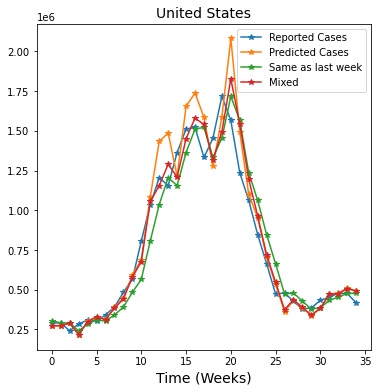

MAPE predictions:  11.258367806145941
MAPE same:  13.297961970530784
MAPE mixed:  9.698328848876038

Week 2


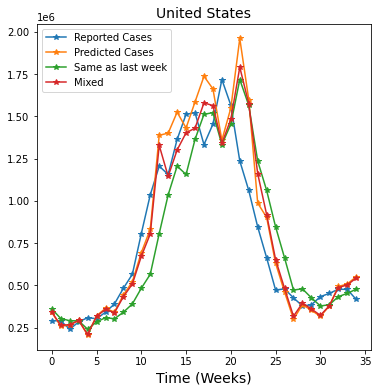

MAPE predictions:  17.125087975366995
MAPE same:  24.532969891797347
MAPE mixed:  16.096159325330962

Week 3


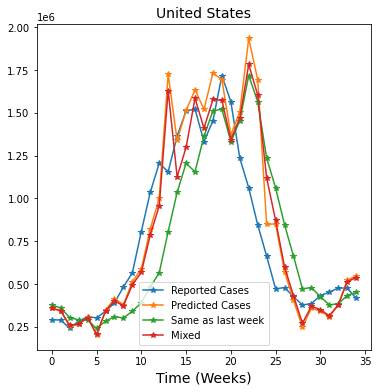

MAPE predictions:  22.703518139066748
MAPE same:  34.12934210222691
MAPE mixed:  23.521203266654265

Week 4


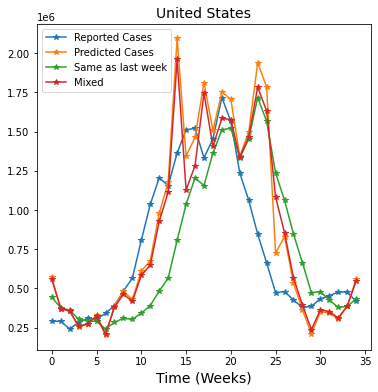

MAPE predictions:  33.379572934119686
MAPE same:  45.79352567464353
MAPE mixed:  35.107897426375104


In [12]:
for region in all_regions:
    for i in range(4):
        start_week= 3-i
        end_week = -1 * (i+1)
        
        print('\nWeek ' + str(i+1))
        real_cases = np.array(results_dict[region]['Real_Cases_W_'+str(i+1)])[start_week:end_week]

        predicted_cases = np.array(results_dict[region]['Predicted_Cases_W_'+str(i+1)])[start_week:end_week]
        same_as_last = np.array(results_dict[region]['Sames_as_last_W_'+str(i+1)])[start_week:end_week]
        mixed = np.array(results_dict[region]['Mixed_Cases_W_'+str(i+1)])[start_week:end_week]

        plt.figure(figsize=(6,6))
        plt.title(region, fontsize=14)
        plt.plot(real_cases, '-*')
        plt.plot(predicted_cases, '-*')
        plt.plot(same_as_last, '-*')
        plt.plot(mixed, '-*')
        plt.legend(['Reported Cases', 'Predicted Cases', 'Same as last week', 'Mixed'])
        plt.xlabel('Time (Weeks)', fontsize=14)

        plt.show()

        mape_predicted, _ = MAPE(real_cases[start_week:end_week], 
                                 predicted_cases[start_week:end_week], np.mean)
        mape_same, _ = MAPE(real_cases[start_week:end_week], 
                            same_as_last[start_week:end_week], np.mean)
        mape_mixed, _ = MAPE(real_cases[start_week:end_week], mixed[start_week:end_week], np.mean)

        print('MAPE predictions: ', mape_predicted)
        print('MAPE same: ', mape_same)
        print('MAPE mixed: ', mape_mixed)

In [13]:
pickle.dump(results_dict, open('US_results.pkl', 'wb'))